<a href="https://colab.research.google.com/github/noahvlone/Project-Recommender-System/blob/main/recommender_system_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval

# Data Load and Read Data

In [2]:
# Load data
titles = pd.read_csv('/content/titles.csv')
credits = pd.read_csv('/content/credits.csv')

# Cek struktur data
print(titles.info())
print(credits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

# Data Cleaning

In [3]:
def parse_genres(genre_str):
    # Check if genre_str is a string before attempting strip
    if isinstance(genre_str, str):
        if pd.isna(genre_str) or genre_str == '[]':
            return []
        # Hilangkan tanda kutip dan kurung, lalu split berdasarkan koma
        genres = genre_str.strip("[]").replace("'", "").replace('"', "").split(',')
        return [g.strip() for g in genres if g.strip() != '']
    # If genre_str is already a list, return it as is
    elif isinstance(genre_str, list):
        return genre_str
    else:
        return []

# Terapkan ke kolom genres
titles['genres'] = titles['genres'].fillna('[]').apply(parse_genres)

# Handle deskripsi kosong
titles['description'] = titles['description'].fillna('')

# Handle IMDb score kosong
titles['imdb_score'] = titles['imdb_score'].fillna(0)

# Filter hanya film (bukan TV Show)
movies = titles[titles['type'] == 'MOVIE'].copy()

# Ambil nama aktor dan direktor dari credits
credits['role'] = credits['role'].str.upper()
actors = credits[credits['role'] == 'ACTOR'].groupby('id')['name'].apply(list).reset_index()
directors = credits[credits['role'] == 'DIRECTOR'].groupby('id')['name'].apply(list).reset_index()

# Gabungkan ke movies
movies = movies.merge(actors, on='id', how='left').rename(columns={'name': 'actors'})
movies = movies.merge(directors, on='id', how='left').rename(columns={'name': 'directors'})

In [4]:
# Cek contoh genres setelah cleaning
print(movies['genres'].head())

0                         [drama, crime]
1    [drama, action, thriller, european]
2              [fantasy, action, comedy]
3                          [war, action]
4                               [comedy]
Name: genres, dtype: object


# Exploratory Data Analysis

<ipython-input-5-a3971efc7653>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genres_count.values, y=genres_count.index, palette='viridis')


Text(0.5, 1.0, 'Distribusi IMDb Score')

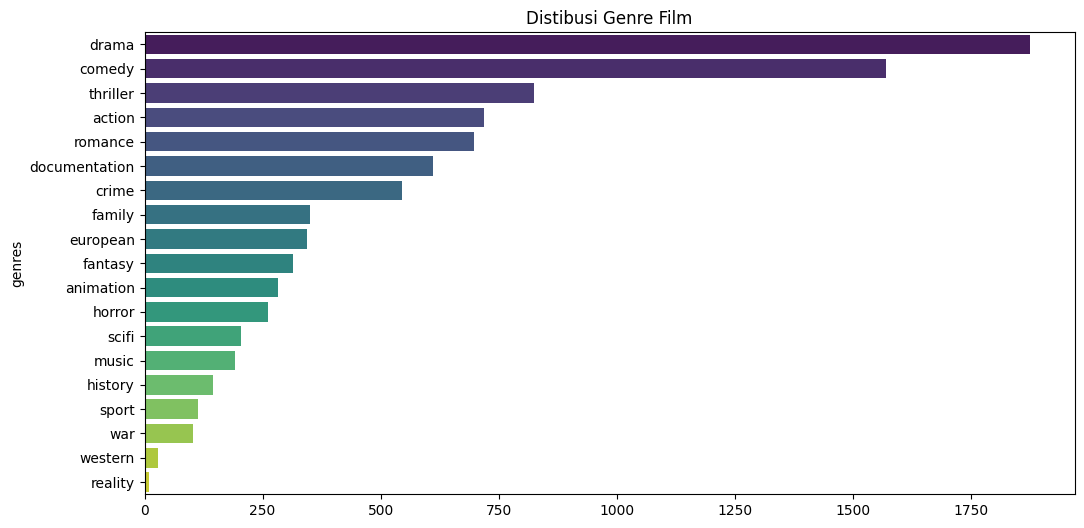

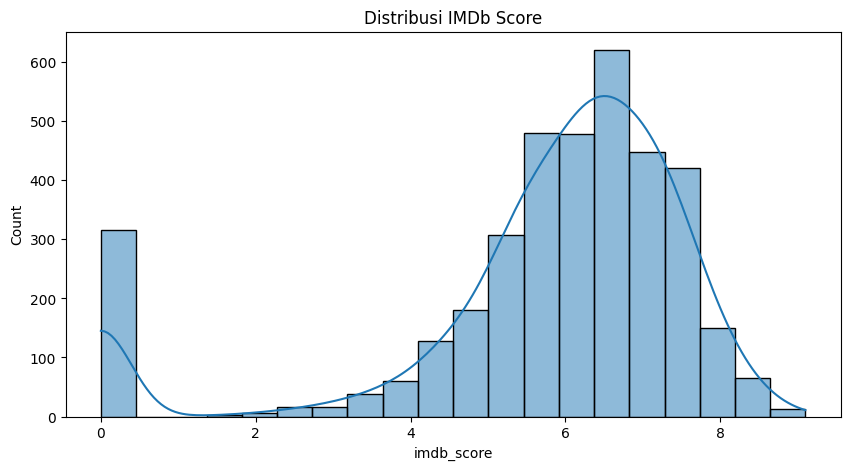

In [5]:
# Distibusi Genre
genres_count = movies['genres'].explode().value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genres_count.values, y=genres_count.index, palette='viridis')
plt.title('Distibusi Genre Film')

# Distribusi IMDb score
plt.figure(figsize=(10, 5))
sns.histplot(movies['imdb_score'].dropna(), bins=20, kde=True)
plt.title('Distribusi IMDb Score')

# Data Preprocessing

In [6]:
# Gabungkan fitur: genre + deskripsi + aktor + direktor
movies['actors'] = movies['actors'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
movies['directors'] = movies['directors'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

# Gabungkan semua fitur teks
movies['features'] = (
    movies['genres'].astype(str) + ' ' +
    movies['description'] + ' ' +
    movies['actors'] + ' ' +
    movies['directors']
)

# Contoh cek data
print(movies[['title', 'features']].head(1))

         title                                           features
0  Taxi Driver  ['drama', 'crime'] A mentally unstable Vietnam...


# Model Development (Content Based-Filtering)

### Hitung Similarity Matrix & Buat Fungsi Rekomendasi

In [7]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies['features'])

# Hitung similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [8]:
# Fungsi rekomendasi dengan error handling
def get_recommendations(title, top_n=10):
  try:
    # Cari Index film
    idx = movies[movies['title'] == title].index[0]

    # Ambil similarity score
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Ambil top_n rekomendasi (exclude film itu sendiri)
    sim_indices = [i[0] for i in sim_scores[1:top_n+1]]

    # Return judul, genre, IMDb score, actors, directors dan similarity score
    recommendations = movies.iloc[sim_indices][['title', 'genres', 'imdb_score', 'actors', 'directors']]
    recommendations['similarity_score'] = [i[1] for i in sim_scores[1:top_n+1]]
    return recommendations

  except:
    return 'Film tidak ditemukan dalam database'

# Evaluasi Model

### Evaluasi Kualitas Rekomendasi

In [9]:
# Contoh evaluasi rekomendasi untuk film 'The Platform'
recommendations = get_recommendations('The Platform', top_n=10)

# Hitung proporsi film niche (IMDb <= 7.0)
niche_movies = recommendations[recommendations['imdb_score'] <= 7.0]
niche_percentage = (len(niche_movies) / len(recommendations)) * 100
print(f'Proporsi Konten Niche: {niche_percentage:.2f}%')

# Cek kesamaan genre dengan film target
target_genres = movies[movies['title'] == 'The Platform']['genres'].iloc[0]
recommended_genres = recommendations['genres'].explode().value_counts()

print('\nGenre Rekomendasi:')
print(recommended_genres)

Proporsi Konten Niche: 100.00%

Genre Rekomendasi:
genres
action           7
thriller         7
crime            6
drama            6
european         4
comedy           4
fantasy          2
scifi            2
documentation    1
romance          1
war              1
Name: count, dtype: int64


### Visualisasi Hasil

<ipython-input-10-6465f636d9b2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recommendations['similarity_score'], y=recommendations['title'], palette='mako')


Text(0.5, 1.0, 'Distribusi IMDb Score Rekomendasi')

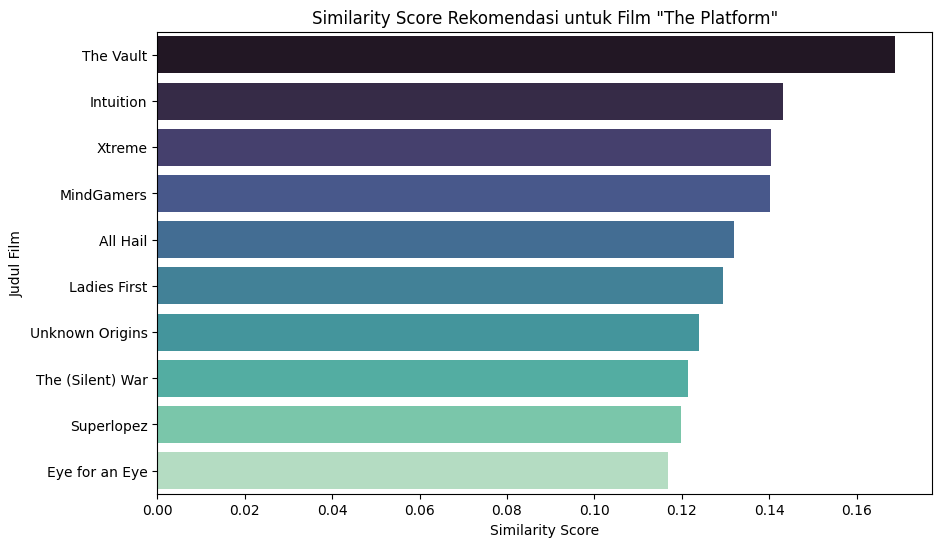

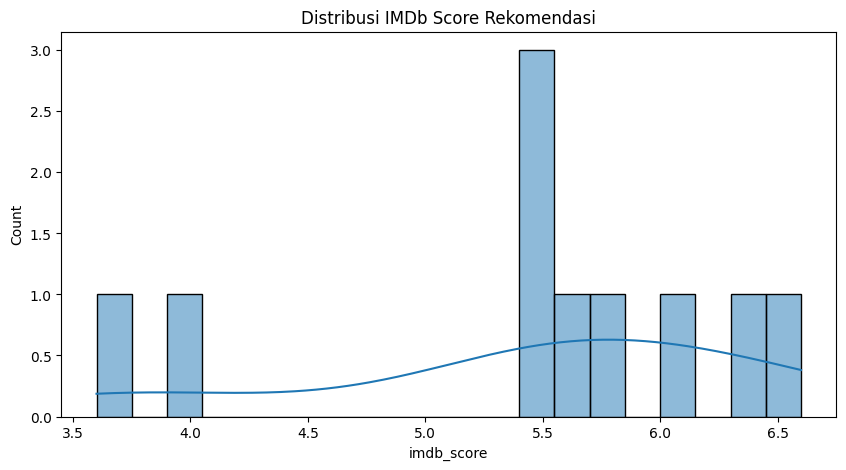

In [10]:
# Plot similarity score
plt.figure(figsize=(10, 6))
sns.barplot(x=recommendations['similarity_score'], y=recommendations['title'], palette='mako')
plt.title('Similarity Score Rekomendasi untuk Film "The Platform"')
plt.xlabel('Similarity Score')
plt.ylabel('Judul Film')

# Cek kesamaan genre dengan film target
plt.figure(figsize=(10, 5))
sns.histplot(recommendations['imdb_score'], bins=20, kde=True)
plt.title('Distribusi IMDb Score Rekomendasi')

### Uji Model dengan Contoh

#### Contoh Rekomendasi I: Film Populer

In [13]:
# Rekomendsi untuk 'Sherlock Holmes'
rec = get_recommendations('Sherlock Holmes', top_n=10)
print('\nRekomendasi untuk film yang mirip "Sherlock Holmes": ')
print(rec[['title', 'genres', 'directors', 'actors', 'imdb_score']])


Rekomendasi untuk film yang mirip "Sherlock Holmes": 
                                   title                             genres  \
493   Sherlock Holmes: A Game of Shadows          [action, crime, thriller]   
83                                Snatch                    [crime, comedy]   
178                  Catch Me If You Can                     [drama, crime]   
233                      How Do You Know           [comedy, drama, romance]   
102                               Eraser   [thriller, action, drama, crime]   
2050                        The Irishman  [crime, drama, history, thriller]   
2046                       The Gentlemen            [crime, action, comedy]   
492                            Contagion   [drama, thriller, scifi, action]   
860                               Loving                   [drama, romance]   
488                     Django Unchained                   [western, drama]   

              directors                                             actors 

#### Contoh Rekomendasi II: Film Niche

In [12]:
# Rekomendasi untuk film niche (contoh: "The Cloverfield Paradox")
cloverfield_rec = get_recommendations("The Cloverfield Paradox", top_n=5)
print("\nRekomendasi untuk Film Niche:")
print(cloverfield_rec[['title', 'imdb_score']])


Rekomendasi untuk Film Niche:
                                   title  imdb_score
238                              The One         5.9
1568  Greg Davies: You Magnificent Beast         7.1
2159                       The Water Man         5.4
3629                     One Lagos Night         6.6
1349                           The Saint         4.9


# Save Model

In [14]:
pickle.dump(tfidf, open('tfidf_model.pkl', 'wb'))
pickle.dump(cosine_sim, open('cosine_sim.pkl', 'wb'))